In [1]:
import sys
import os
import numpy as np
import time
from scipy.optimize import differential_evolution, minimize, dual_annealing, minimize
import matplotlib.pyplot as plt

import concurrent.futures
import threading
#import pandas as pd
sys.path.append("./../")

from minionpy.test import MWUT
from minionpy import *

# Evaluate CEC Problem and Repeat for N times using multithreading

In [3]:
# Global results variable
results = []
results_lock = threading.Lock()

algos = ["LSHADE", "NLSHADE_RSP", "j2020", "jSO", "LSRTDE", "GWO_DE", "DE", "JADE", "ARRDE"]
algos = ["LSRTDE", "ARRDE"]

def test_optimization_threadsafe(func, bounds, dimension, func_name, Nmaxeval, seed):
    global results
    result = {}
    result['Dimensions'] = dimension
    result['Function'] = func_name
    bounds_list = [bounds] * dimension
    x0 = [0.0 for _ in range(dimension)]

    for algo in algos :
        res =Minimizer (func, bounds_list, x0=None, relTol=0.0,  algo=algo, maxevals=Nmaxeval, callback=None, seed=seed, options={"population_size": 0}).optimize()
        result[algo] = res.fun

    def func_scipy (par) : 
        return func([par])[0]
    
    dual_ann = dual_annealing(func_scipy, bounds_list, maxfun=Nmaxeval)
    result["ANNEALING"] = dual_ann.fun

    simp= minimize(func_scipy, x0=x0, method="Nelder-Mead", options={"adaptive":True})
    result["Simplex"] = simp.fun

    with results_lock:
        results.append(result)
    print(result)

def run_test_optimization(j, dim, year=2017, seed=None):
    if year== 2014 : cec_func = CEC2014Functions(function_number=j, dimension=dim)
    elif year== 2017 : cec_func = CEC2017Functions(function_number=j, dimension=dim)
    elif year== 2019 : cec_func = CEC2019Functions(function_number=j)
    elif year== 2020 : cec_func = CEC2020Functions(function_number=j, dimension=dim)
    elif year== 2022 : cec_func = CEC2022Functions(function_number=j, dimension=dim)
    else : raise Exception("Unknown CEC year.")
    test_optimization_threadsafe(cec_func, (-100, 100), dim, "func_" + str(j), Nmaxeval, seed)



##-------------------------------##
Nmaxeval = 10000
dimension = 10
NRuns= 1
year = 2020

func_numbers_dict = {
    2022 :  [1,2,3,4,5,6,7, 8, 9,10, 11, 12] , 
    2020 : [1,2,3,4,5,6,7, 8, 9,10], 
    2019 : [1,2,3,4,5,6,7, 8, 9,10], 
    2017 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], 
    2014 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
}
func_numbers= func_numbers_dict[year]


with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    futures = []
    for k in range(NRuns):
        for j in func_numbers:
            futures.append(executor.submit(run_test_optimization, j, dimension, year, k))
    concurrent.futures.wait(futures)
    for f in futures: f.result()

for num in func_numbers : 
    mydict= {}
    algoRes = {algo : [] for algo in algos}
    for res in list(results) : 
        for algo in algoRes.keys() : 
            if res['Function'] == "func_"+str(num) :
                algoRes[algo].append(res[algo])

    full_results= {}
    for key, val in algoRes.items() : 
        full_results[key] = (np.min(val), np.mean(val), np.std(val)) #best, average, std
    print("Full results for function "+str(num) +":\n\t", full_results)


{'Dimensions': 10, 'Function': 'func_1', 'LSRTDE': 103.77192151333018, 'ARRDE': 100.20911221832844, 'ANNEALING': 100.00000378856643, 'Simplex': 1660966388.2416496}
{'Dimensions': 10, 'Function': 'func_2', 'LSRTDE': 2259.400738110319, 'ARRDE': 1162.9744794619983, 'ANNEALING': 2021.731974433535, 'Simplex': 4026.2321844700386}
{'Dimensions': 10, 'Function': 'func_3', 'LSRTDE': 737.9113806300074, 'ARRDE': 713.9551876810483, 'ANNEALING': 743.1842168111674, 'Simplex': 824.0313677580956}
{'Dimensions': 10, 'Function': 'func_4', 'LSRTDE': 1902.3454325134305, 'ARRDE': 1901.7025809647719, 'ANNEALING': 1900.5972096456424, 'Simplex': 1900.0}
{'Dimensions': 10, 'Function': 'func_5', 'LSRTDE': 1706.3016442691346, 'ARRDE': 1844.6958472668907, 'ANNEALING': 2040.090146447557, 'Simplex': 50802.73146288246}
{'Dimensions': 10, 'Function': 'func_6', 'LSRTDE': 1601.9608240661848, 'ARRDE': 1601.9405502785123, 'ANNEALING': 1952.0787924896956, 'Simplex': 2382.702624461672}
{'Dimensions': 10, 'Function': 'func_

## Fit Polynomial

[0.7468588055836325, 0.937081325641864, 0.7383890804278399, 0.06171138311119795, -0.5345433440454186, -0.9772023914451402, -0.13906236341501899, -0.19529727992527035, 0.04534934270513924, -0.04321640839519514]


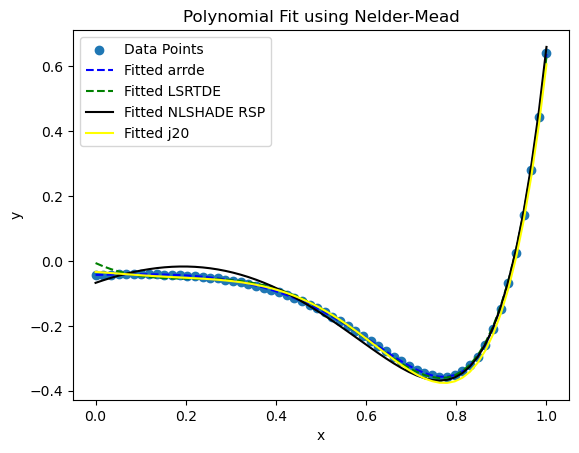


Obj ARRDE :   7.375477409483513e-05
Obj LSRTDE :   2.4106696428943984e-08
Obj NLSHADE RSP :   0.0002804644661074913
Obj lshade:   0.030072210446930005
Obj j20 :   0.00014384224471735685
Obj jSO :   2.2456231866998823e-05
Obj da :   8.794960852534012e-07


In [2]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

dimension=10
# Step 1: Generate data points from a polynomial 
np.random.seed(8)  # For reproducibility

# True coefficients of the polynomial (degree 10)
true_coefficients = [np.random.uniform(-1.0, 1.0)*1.0**i for i in range(dimension)]  # Random coefficients for the polynomial
print(true_coefficients)

# Generate 50 data points
x_data = np.linspace(0.0, 1, dimension+50)
y_data = (np.polyval(true_coefficients, x_data))

# Step 2: Define the polynomial model
def polynomial_model(x, coefficients):
    """Given x and coefficients, return the polynomial value."""
    return (np.polyval(coefficients, x))

# Step 3: Define the objective function to minimize
def objective_function(coefficients, x, y):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = polynomial_model(x, coefficients)
    return np.mean((y - y_pred)**2)

def objective_function_vect(coefficients) : 
    ret = []
    for coeff in coefficients : 
        ret.append(objective_function(coeff, x_data, y_data))
    return ret

def objective_function_ind (coeff) : 
    return objective_function_vect([coeff])[0]

bounds= [(-10, 10)]*dimension
Nmaxeval= 5000  #1000*dimension

# Optimize the coefficients using Nelder-Mead
#result = opt.minimize(objective_function, np.ones(dimension), args=(x_data, y_data), method='Nelder-Mead', options={"maxfev":Nmaxeval, "adaptive":True }  ) 

result_arrde = ARRDE(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
#result_arrde = opt.minimize(objective_function, result_arrde.x, args=(x_data, y_data), method='Nelder-Mead', options={"maxfev":int(0.05*Nmaxeval), "adaptive":True }  ) 

result_lsrtde = LSRTDE(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0} ).optimize()
result_lshade = LSHADE(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
result_jso = jSO(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
result_nlshadersp = NLSHADE_RSP (objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
result_j20 = j2020(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
#result_de = differential_evolution(objective_function, bounds, args=(x_data, y_data), popsize=3, strategy='best1exp',
#                                         maxiter=int(Nmaxeval/(3*dimension)), vectorized=False, disp=False,polish=False)

dual_ann = dual_annealing(objective_function_ind, bounds, maxfun=Nmaxeval)
# Step 5: Extract the fitted coefficients

#fitted_coefficients_nm = result.x
fitted_coefficients_arrde = result_arrde.x
fitted_coefficients_lsrtde = result_lsrtde.x
fitted_coefficients_nlshade = result_nlshadersp.x
fitted_coefficients_j20= result_j20.x
#fitted_coefficients_de= result_de.x
fitted_coefficients_lshade= result_lshade.x

# Step 6: Plot the results
plt.scatter(x_data, y_data, label='Data Points')
#plt.plot(x_data, np.polyval(true_coefficients, x_data), 'r-', label='True Polynomial')
#plt.plot(x_data, np.polyval(fitted_coefficients_nm, x_data), 'g--', label='Fitted nm')
plt.plot(x_data, polynomial_model(x_data, fitted_coefficients_lsrtde, ), 'b--', label='Fitted arrde')
plt.plot(x_data, polynomial_model(x_data, fitted_coefficients_arrde, ), 'g--', label='Fitted LSRTDE')
plt.plot(x_data, polynomial_model(x_data, fitted_coefficients_nlshade, ), 'black', label='Fitted NLSHADE RSP')
plt.plot(x_data, polynomial_model(x_data, fitted_coefficients_j20, ), 'yellow', label='Fitted j20')
plt.legend()
plt.title('Polynomial Fit using Nelder-Mead')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Display the true and fitted coefficients
#print("True coefficients:    ", true_coefficients)
#print("Fitted coefficients NM :  ", fitted_coefficients_nm)
#print("Fitted coefficients ARRDE :  ", fitted_coefficients_arrde)

print("")

#print("Obj NM :  ",result.fun)
print("Obj ARRDE :  ", result_arrde.fun)
print("Obj LSRTDE :  ", result_lsrtde.fun)
print("Obj NLSHADE RSP :  ", result_nlshadersp.fun)
print("Obj lshade:  ", result_lshade.fun)
print("Obj j20 :  ", result_j20.fun)
print("Obj jSO :  ", result_jso.fun)
print("Obj da :  ", dual_ann.fun)

## Fit Gaussian Mixture Model

In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


np.random.seed(5)  # For reproducibility
num_rbf = 10

true_centers = 10*(-1+2*np.random.random(num_rbf))
true_widths = np.random.rand(num_rbf) + 1.0  # Widths (variances)
true_coeffs = 2.0*np.random.rand(num_rbf)
print(true_centers)
print(true_widths)
print(true_coeffs)
dimension= num_rbf*3

# Define a Gaussian RBF function
def rbf(x, center, width):
    """Compute a Gaussian RBF value given x, center, and width."""
    return (1.0/2.0*np.pi*width**2)*0.5  * np.exp(-((x - center) ** 2) / (2 * width ** 2))

# Define the function as a sum of RBFs
def rbf_sum(x, centers, widths, coeffs):
    """Sum of Gaussian RBFs."""
    result = np.zeros_like(x)
    coeffs= np.array(coeffs)
    norm_coeff = coeffs/np.sum(coeffs)
    for i in range(len(centers)):
        result += norm_coeff[i] * rbf(x, centers[i], widths[i])
    return result


# Generate 50 data points
x_data = np.linspace(-20, 20,dimension+50)
y_data = rbf_sum(x_data, true_centers, true_widths, true_coeffs)  # Add some noise


# Step 2: Define the model for fitting
def rbf_model(x, params):
    """RBF model with combined parameters (centers, widths, and coefficients)."""
    num_rbf = len(params) // 3
    centers = params[:num_rbf]
    widths = params[num_rbf:2*num_rbf]
    coeffs = params[2*num_rbf:]
    return rbf_sum(x, centers, widths, coeffs)

def rbf_data(params):
    """RBF model with combined parameters (centers, widths, and coefficients)."""
    num_rbf = len(params) // 3
    centers = params[:num_rbf]
    widths = params[num_rbf:2*num_rbf]
    coeffs = params[2*num_rbf:]
    return rbf_sum(x_data, centers, widths, coeffs)

# Step 3: Define the objective function to minimize
def objective_function(params):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = rbf_model(x_data, params)
    return np.mean((y_data - y_pred) ** 2)




executor = concurrent.futures.ThreadPoolExecutor(max_workers=4)
def objective_function_vect(params) : 
    #ret = []
    #for p in params : 
    #    ret.append(objective_function(p, x_data, y_data))
    ret = list(executor.map(objective_function, params))
    return ret


initial_guess = np.concatenate([
    np.linspace(-100, 100, num_rbf),  # Initial guess for centers
    np.ones(num_rbf),  # Initial guess for widths
    np.zeros(num_rbf)  # Initial guess for coefficients
])


bounds= [(-10, 10)]*dimension
Nmaxeval=50000#5000*dimension

# Optimize the coefficients using Nelder-Mead
dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval)
#result = opt.minimize(objective_function, initial_guess, args=(), method='Nelder-Mead', options={"maxfev":Nmaxeval, "adaptive":True }  ) 
#print("SIMPLEX done")
result_arrde = ARRDE(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
print("ARRDE done")
result_lsrtde = LSRTDE(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0} ).optimize()
print("LSRTDE done")
result_lshade = LSHADE(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
print("LSHADE done")
result_nlshadersp = NLSHADE_RSP (objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
print("RSP done")
result_j20 = j2020(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
print("j20 done")
result_jso = jSO(objective_function_vect,bounds, x0=None, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
#result_de = differential_evolution(objective_function, bounds, args=(x_data, y_data), popsize=1, strategy='best1bin',
#                                         maxiter=int(Nmaxeval/(3*dimension)), vectorized=False, disp=False,polish=False)
#print("DE done")


plt.plot(x_data, y_data, label="data", color="black")
plt.plot(x_data, rbf_data(result_arrde.x), label="ARRDE")
plt.plot(x_data, rbf_data(result_lsrtde.x), label="LSRTDE")
plt.plot(x_data, rbf_data(result_nlshadersp.x), label="NLSHADE RSP")
#plt.plot(x_data, rbf_data(result_j20.x), label="j2020")
plt.legend()


print("")
#
#print("Obj NM :  ",result.fun)
print("Obj ARRDE :  ", result_arrde.fun)
print("Obj LSRTDE :  ", result_lsrtde.fun)
print("Obj NLSHADE RSP :  ", result_nlshadersp.fun)
print("Obj lshade:  ", result_lshade.fun)
print("Obj j20 :  ", result_j20.fun)
print("Obj jSO :  ", result_jso.fun)
print("Obj da   : ", dual_ann.fun)

executor.shutdown()


## Fit CT18 PDFs

In [ ]:
import math
class CT18PDFs : 
    def __init__(self) : 
        self.parameters = {
            "uv_0" : 3.385, "uv_1" : 0.763, "uv_2" : 3.036, "uv_3" : 1.502, "uv_4" : -0.147,"uv_5" : 1.671, "uv_6" : 0.,
            "dv_0" : 0.490, "dv_1" : 0.763, "dv_2" : 3.036, "dv_3" : 2.615, "dv_4" : 1.828,"dv_5" : 2.721, "dv_6" : 0., 
            "g_0" : 2.690, "g_1" : 0.531, "g_2" : 3.148, "g_3" : 3.032, "g_4" : -1.705, "g_5" : 1.354, 
            "ubar_0" : 0.414, "ubar_1" : -0.022, "ubar_2" : 7.737, "ubar_3" : 4.0, "ubar_4" : 0.618,"ubar_5" : 0.195, "ubar_6" : 0.871, "ubar_7" : 0.267,"ubar_8" : 0.733,
            "dbar_0" : 0.414, "dbar_1" : -0.022, "dbar_2" : 7.737, "dbar_3" : 4.0, "dbar_4" : 0.292,"dbar_5" : 0.647, "dbar_6" : 0.474, "dbar_7" : 0.741,"dbar_8" :1.0,
            "s_0" : 0.288, "s_1" : -0.022, "s_2" : 10.31, "s_3" : 4.0, "s_4" : 0.466,"s_5" : 0.466, "s_6" : 0.225, "s_7" : 0.225,"s_8" : 1.0,
        }
        self.xlist = np.linspace(1e-3, 0.8, 100)
        self.paramNames = list(self.parameters.keys())
        self.originalData = self.getData()

    def uv(self, x) : 
        a0 = self.parameters["uv_0"]
        a1 = self.parameters["uv_1"]
        a2 = self.parameters["uv_2"]
        a3 = self.parameters["uv_3"]
        a4 = self.parameters["uv_4"]
        a5 = self.parameters["uv_5"]
        a6 = self.parameters["uv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dv(self, x) : 
        a0 = self.parameters["dv_0"]
        a1 = self.parameters["dv_1"]
        a2 = self.parameters["dv_2"]
        a3 = self.parameters["dv_3"]
        a4 = self.parameters["dv_4"]
        a5 = self.parameters["dv_5"]
        a6 = self.parameters["dv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def g(self, x) : 
        a0 = self.parameters["g_0"]
        a1 = self.parameters["g_1"]
        a2 = self.parameters["g_2"]
        a3 = self.parameters["g_3"]
        a4 = self.parameters["g_4"]
        a5 = self.parameters["g_5"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**3 + np.sinh(a4) *3*y*(1-y)**2 + np.sinh(a5) *3*y**2*(1-y)  + y**3
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def ubar(self, x) : 
        a0 = self.parameters["ubar_0"]
        a1 = self.parameters["ubar_1"]
        a2 = self.parameters["ubar_2"]
        a3 = self.parameters["ubar_3"]
        a4 = self.parameters["ubar_4"]
        a5 = self.parameters["ubar_5"]
        a6 = self.parameters["ubar_6"]
        a7 = self.parameters["ubar_7"]
        a8 = self.parameters["ubar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dbar(self, x) : 
        a0 = self.parameters["dbar_0"]
        a1 = self.parameters["dbar_1"]
        a2 = self.parameters["dbar_2"]
        a3 = self.parameters["dbar_3"]
        a4 = self.parameters["dbar_4"]
        a5 = self.parameters["dbar_5"]
        a6 = self.parameters["dbar_6"]
        a7 = self.parameters["dbar_7"]
        a8 = self.parameters["dbar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def s(self, x) : 
        a0 = self.parameters["s_0"]
        a1 = self.parameters["s_1"]
        a2 = self.parameters["s_2"]
        a3 = self.parameters["s_3"]
        a4 = self.parameters["s_4"]
        a5 = self.parameters["s_5"]
        a6 = self.parameters["s_6"]
        a7 = self.parameters["s_7"]
        a8 = self.parameters["s_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def u(self, x) : return self.uv(x)+self.ubar(x)
    def d(self, x) : return self.dv(x)+self.dbar(x) 

    def setParameter(self, pars) : 
        assert(len(pars)==len(self.parameters)) 
        self.parameters= dict(zip(self.paramNames, pars))

    def getData(self) : 
        x= self.xlist
        return [ x*self.u(self.xlist), x*self.ubar(self.xlist), x*self.d(self.xlist), x*self.dbar(self.xlist), x*self.g(self.xlist), x*self.s(self.xlist)]
    
    def chi2(self, params) : 
        self.setParameter(params) 
        data = self.getData() 
        ret =0
        for do, d in zip(self.originalData, data) : 
            ret = ret + np.sum((do-d)**2)
        return ret 
    
    def chi2_vect(self, params, data=None) : 
        return [self.chi2(p) for p in params ]


ct18 = CT18PDFs() 
data = ct18.getData() 
plt.plot(ct18.xlist, data[0], label="u")
plt.plot(ct18.xlist, data[1],  label="ubar")#
plt.plot(ct18.xlist, data[2],  label="d")
plt.plot(ct18.xlist, data[3],  label="dbar")
plt.plot(ct18.xlist, data[4],  label="g")
plt.plot(ct18.xlist, data[5],  label="s")
#plt.xscale("log")
plt.legend()
plt.xlim(0.1, 0.8)

In [ ]:
dimension = 47
print("Dimension : ", dimension)
bounds= [(-10, 10)]*dimension
Nmaxeval=5000

# Optimize the coefficientÄs using Nelder-Mead

algos = ["LSHADE", "NLSHADE_RSP", "j2020", "jSO", "LSRTDE", "GWO_DE", "DE", "JADE", "ARRDE"]
algos = ["LSRTDE", "ARRDE"]


results = []
for i in range(3) :
    result = {}
    #result = opt.minimize(objective_function, initial_guess, args=(), method='Nelder-Mead', options={"maxfev":Nmaxeval, "adaptive":True }  ) 
    #print("SIMPLEX done")
    for algo in algos :
        res = Minimizer(ct18.chi2_vect,bounds, x0=None,algo=algo, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=i+2, options={"population_size": 0} ).optimize()
        print("\tObj ", algo, " :  ", res.fun)
        result[algo] = res.fun

    print("")
    results.append(result)

    
algoRes = {algo :[] for algo in algos}
for algo in algoRes.keys() : 
    for res in results : algoRes[algo].append(res[algo])

for algo in algoRes : 
    print (algo, " : ", MWUT(algoRes["ARRDE"], algoRes[algo]), np.mean( algoRes[algo]))
